In [2]:
import numpy as np
import pandas as pd
import os, sys
import glob


from datetime import datetime, time

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter


import geopandas as gpd
from shapely.geometry import Point

import xarray as xr

import supermag_api


import plotly.express as px
import plotly.graph_objs as go

from scipy.integrate import trapz

from scipy.stats import genextreme, genpareto
from pyextremes import get_return_periods




/Users/ryanmc/opt/anaconda3/envs/spwxr_network/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Load regions
regions_gdf = gpd.read_file("/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/NERC_Reliability_Coordinators.geojson")
# Ensure the CRS is WGS84 (EPSG:4326)
if regions_gdf.crs is None or regions_gdf.crs.to_string() != "EPSG:4326":
    print('converting to EPSG: 4326')
    regions_gdf = regions_gdf.to_crs("EPSG:4326")


/Users/ryanmc/opt/anaconda3/envs/spwxr_network/lib/python3.9/site-packages/geopandas/io/file.py:364: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/Users/ryanmc/opt/anaconda3/envs/spwxr_network/lib/python3.9/site-packages/geopandas/io/file.py:364: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


In [4]:
regions_gdf

,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,TELEPHONE,COUNTRY,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,WEBSITE,ABBRV,SHAPE_Length,SHAPE_Area,geometry
0,1,2775,CALIFORNIA INDEPENDENT SYSTEM OPERATOR,250 OUTCROPPING WAY,FOLSOM,CA,95630,(916) 351-4400,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,http://www.caiso.com/,RCW,223.350632,225.375431,"MULTIPOLYGON (((-117.21222 32.77345, -117.2125..."
1,2,56669,"MIDCONTINENT INDEPENDENT SYSTEM OPERATOR, INC..",720 WEST CITY CENTER DRIVE,CARMEL,IN,46032,(317) 249-5400,USA,"FERC 714, EIA 860, EIA 861, TIGER/Line Shapefi...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,https://www.misoenergy.org/,MISO,292.720754,149.525223,"MULTIPOLYGON (((-90.86519 29.04521, -90.86601 ..."
2,3,59504,SOUTHWEST POWER POOL,201 WORTHEN DRIVE,LITTLE ROCK,AR,72223,(501) 614-3200,USA,"FERC 714, EIA 860, EIA 861, TIGER/Line Shapefi...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,https://www.spp.org/,SPP,124.080895,159.549276,"MULTIPOLYGON (((-90.02360 36.26603, -90.02347 ..."
3,4,14725,"PJM INTERCONNECTION, LLC",2750 MONROE BOULEVARD,AUDUBON,PA,19403,(610) 666-8980,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,http://www.pjm.com/,PJM,180.400515,60.380160,"MULTIPOLYGON (((-76.74164 34.93144, -76.74147 ..."
4,5,5723,ERCOT ISO,7620 METRO CENTER DRIVE,AUSTIN,TX,78744,(512) 225-7000,USA,"EIA 861, http://www.nerc.com/",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,http://www.ercot.com/,ERCOT,129.617465,61.005352,"MULTIPOLYGON (((-97.19964 26.00022, -97.19972 ..."
5,6,18195,"SOUTHERN COMPANY SERVICES, INC.",30 IVAN ALLEN JR. BLVD. NW,ATLANTA,GA,30308,(404) 506-5000,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,https://www.southerncompany.com/,SOCO,63.918457,31.514459,"MULTIPOLYGON (((-85.71473 30.11996, -85.71406 ..."
6,7,18642,TENNESSEE VALLEY AUTHORITY,400 W. SUMMIT HILL DR,KNOXVILLE,TN,37902,(865) 632-2101,USA,"FERC 714, EIA 860, EIA 861, TIGER/Line Shapefi...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,https://www.tva.gov/,TVA,76.634818,34.343868,"MULTIPOLYGON (((-89.63085 33.18303, -89.54331 ..."
7,8,NA3,VACAR SOUTH,DEC-43A/550 SOUTH TRYON STREET,CHARLOTTE,NC,28202,NOT AVAILABLE,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,NOT AVAILABLE,VACS,95.622322,19.661130,"MULTIPOLYGON (((-80.88014 32.07804, -80.88029 ..."
8,9,13434,ISO NEW ENGLAND INC.,1 SULLIVAN RD,HOLYOKE,MA,01040,(413) 535-4000,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,https://www.iso-ne.com/,ISNE,72.611648,16.621284,"MULTIPOLYGON (((-73.42151 40.61798, -73.42155 ..."
9,10,13501,NEW YORK INDEPENDENT SYSTEM OPERATOR,10 KREY BOULEVARD,RENSSELAER,NY,12144,(518) 356-6000,USA,"FERC 714, EIA 860, EIA 861, TIGER/Line Shapefi...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,http://www.nyiso.com/,NYIS,49.321979,14.143104,"MULTIPOLYGON (((-74.05013 40.56642, -74.04944 ..."


In [5]:
# Read in supermag station information 
df_sm_stations = pd.read_csv('/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/supermag_data/supermag-stations-information-downloadedJuly2025.csv',
                            usecols=[0,1,2,3,4,5])




In [6]:
df_sm_stations['GEOLON_alt'] = ((df_sm_stations['GEOLON'] + 180) % 360) - 180

In [7]:
df_sm_stations

,IAGA,GEOLON,GEOLAT,AACGMLON,AACGMLAT,STATION-NAME,GEOLON_alt
0,SON,66.44,25.12,139.81,19.36,Sonmiani,66.44
1,AMU,210.13,61.24,-93.38,61.32,Anchorage,-149.87
2,YKC,245.52,62.48,-56.85,69.42,Yellowknife,-114.48
3,CBB,254.97,69.12,-47.81,77.05,Cambridge Bay,-105.03
4,RES,265.11,74.69,-35.54,82.93,Resolute Bay,-94.89
...,...,...,...,...,...,...,...
593,Y17,279.36,-5.17,-7.96,7.30,Piura,-80.64
594,Y18,283.64,-6.50,-3.57,6.20,Tarapoto,-76.36
595,STT,351.27,37.55,68.41,28.53,Sao Teotonio,-8.73
596,BLO,246.58,43.93,-49.37,50.91,Bear Lake,-113.42


In [8]:
gdf_sm_stations = gpd.GeoDataFrame(
                            df_sm_stations,
                            geometry=[Point(xy) for xy in zip(df_sm_stations["GEOLON_alt"], df_sm_stations["GEOLAT"])],
                            crs="EPSG:4326"
                            )

In [9]:
gdf_sm_stations

,IAGA,GEOLON,GEOLAT,AACGMLON,AACGMLAT,STATION-NAME,GEOLON_alt,geometry
0,SON,66.44,25.12,139.81,19.36,Sonmiani,66.44,POINT (66.44000 25.12000)
1,AMU,210.13,61.24,-93.38,61.32,Anchorage,-149.87,POINT (-149.87000 61.24000)
2,YKC,245.52,62.48,-56.85,69.42,Yellowknife,-114.48,POINT (-114.48000 62.48000)
3,CBB,254.97,69.12,-47.81,77.05,Cambridge Bay,-105.03,POINT (-105.03000 69.12000)
4,RES,265.11,74.69,-35.54,82.93,Resolute Bay,-94.89,POINT (-94.89000 74.69000)
...,...,...,...,...,...,...,...,...
593,Y17,279.36,-5.17,-7.96,7.30,Piura,-80.64,POINT (-80.64000 -5.17000)
594,Y18,283.64,-6.50,-3.57,6.20,Tarapoto,-76.36,POINT (-76.36000 -6.50000)
595,STT,351.27,37.55,68.41,28.53,Sao Teotonio,-8.73,POINT (-8.73000 37.55000)
596,BLO,246.58,43.93,-49.37,50.91,Bear Lake,-113.42,POINT (-113.42000 43.93000)


In [10]:
sm_stations_locations_with_regions = gpd.sjoin(gdf_sm_stations, regions_gdf, how="left", predicate="within")
sm_stations_locations_with_regions['Region'] = sm_stations_locations_with_regions['NAME']
sm_stations_locations_with_regions_US = sm_stations_locations_with_regions.dropna(subset=['Region'], inplace=False)


In [ ]:
# sm_stations_locations_with_regions


In [15]:
sm_stations_locations_with_regions_US[sm_stations_locations_with_regions_US['IAGA'] == 'R05']

,IAGA,GEOLON,GEOLAT,AACGMLON,AACGMLAT,STATION-NAME,GEOLON_alt,geometry,index_right,OBJECTID,...,COUNTRY,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,WEBSITE,ABBRV,SHAPE_Length,SHAPE_Area,Region
557,R05,275.84,41.57,-9.98,51.82,Bluesky,-84.16,POINT (-84.16000 41.57000),3.0,4.0,...,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,http://www.pjm.com/,PJM,180.400515,60.38016,"PJM INTERCONNECTION, LLC"


In [11]:
# read in the GIC sensor locations for May 2024 storm

file_sensor_locations = os.path.join('/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/','risk-resiliency-spwx','data','event_20240510','GIC','gic_monitors.csv')

df_sensor_locations = pd.read_csv(file_sensor_locations)
df_sensor_locations[' Longitude'] = df_sensor_locations[' Longitude'] * -1.

# Convert sensor DataFrame to GeoDataFrame
gdf_sensor_locations = gpd.GeoDataFrame(
                            df_sensor_locations,
                            geometry=[Point(xy) for xy in zip(df_sensor_locations[" Longitude"], df_sensor_locations[" Latitude"])],
                            crs="EPSG:4326"
                            )

In [58]:
# gdf_sensor_locations[' Longitude'] = gdf_sensor_locations[' Longitude'] * -1.

Previous analyses: 
- Closest sensor to FRD SuperMAG station: 10427
- Closest sensor to R07 SuperMAG station: 10297
- Closest sensor to FRN SuperMAG station: 10418 (informed by Bhagyashree to replace 10448)

In [59]:
gdf_sensor_locations#[gdf_sensor_locations['Device ID']==10427]

,Device ID,Latitude,Longitude,Installation Type,Connection,Minimum Value in Measurement Range,geometry
0,10052,44.9,97.0,1 - Separate,1 - Common neutral of a 3-phase transformer,0.10,POINT (-97.00000 44.90000)
1,10064,41.8,88.2,2 - Combined,1 - Common neutral of a 3-phase transformer,0.10,POINT (-88.20000 41.80000)
2,10065,41.8,87.8,2 - Combined,1 - Common neutral of a 3-phase transformer,0.10,POINT (-87.80000 41.80000)
3,10066,41.6,87.9,2 - Combined,1 - Common neutral of a 3-phase transformer,0.10,POINT (-87.90000 41.60000)
4,10067,42.1,87.9,2 - Combined,1 - Common neutral of a 3-phase transformer,0.10,POINT (-87.90000 42.10000)
...,...,...,...,...,...,...,...
373,10575,41.7,86.1,2 - Combined,1 - Common neutral of a 3-phase transformer,0.25,POINT (-86.10000 41.70000)
374,10576,41.7,86.1,2 - Combined,1 - Common neutral of a 3-phase transformer,0.25,POINT (-86.10000 41.70000)
375,10577,41.4,84.9,2 - Combined,1 - Common neutral of a 3-phase transformer,0.25,POINT (-84.90000 41.40000)
376,10578,40.2,82.8,2 - Combined,2 - Common neutral of three (3) single-phase t...,0.25,POINT (-82.80000 40.20000)


In [39]:
sm_stations_locations_with_regions_US

,IAGA,GEOLON,GEOLAT,AACGMLON,AACGMLAT,STATION-NAME,GEOLON_alt,geometry,index_right,OBJECTID,...,COUNTRY,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,WEBSITE,ABBRV,SHAPE_Length,SHAPE_Area,Region
13,BOU,254.76,40.14,-38.69,48.52,Boulder,-105.24,POINT (-105.24000 40.14000),12.0,13.0,...,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,https://www.spp.org/,SPPW,134.250252,94.978328,SOUTHWEST POWER POOL WEST
14,FRN,240.28,37.09,-54.89,42.63,Fresno,-119.72,POINT (-119.72000 37.09000),0.0,1.0,...,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,http://www.caiso.com/,RCW,223.350632,225.375431,CALIFORNIA INDEPENDENT SYSTEM OPERATOR
16,NEW,242.88,48.27,-54.82,54.65,Newport,-117.12,POINT (-117.12000 48.27000),0.0,1.0,...,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,http://www.caiso.com/,RCW,223.350632,225.375431,CALIFORNIA INDEPENDENT SYSTEM OPERATOR
37,FRD,282.63,38.20,-0.64,48.05,Fredericksburg,-77.37,POINT (-77.37000 38.20000),3.0,4.0,...,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,http://www.pjm.com/,PJM,180.400515,60.380160,"PJM INTERCONNECTION, LLC"
45,CDP,256.30,31.00,-35.65,39.45,Chengdu,-103.70,POINT (-103.70000 31.00000),4.0,5.0,...,USA,"EIA 861, http://www.nerc.com/",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,http://www.ercot.com/,ERCOT,129.617465,61.005352,ERCOT ISO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,R10,288.52,42.61,7.85,51.61,Haystack,-71.48,POINT (-71.48000 42.61000),8.0,9.0,...,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,https://www.iso-ne.com/,ISNE,72.611648,16.621284,ISO NEW ENGLAND INC.
574,R11,290.44,44.29,10.61,52.97,Augusta,-69.56,POINT (-69.56000 44.29000),8.0,9.0,...,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,https://www.iso-ne.com/,ISNE,72.611648,16.621284,ISO NEW ENGLAND INC.
575,R12,242.32,47.53,-55.26,53.77,Grant,-117.68,POINT (-117.68000 47.53000),0.0,1.0,...,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,http://www.caiso.com/,RCW,223.350632,225.375431,CALIFORNIA INDEPENDENT SYSTEM OPERATOR
576,R13,256.31,40.21,-36.74,48.85,Pawnee,-103.69,POINT (-103.69000 40.21000),12.0,13.0,...,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,https://www.spp.org/,SPPW,134.250252,94.978328,SOUTHWEST POWER POOL WEST


In [62]:
sm_stations_locations_with_regions_US[sm_stations_locations_with_regions_US['IAGA']==target_station]

,IAGA,GEOLON,GEOLAT,AACGMLON,AACGMLAT,STATION-NAME,GEOLON_alt,geometry,index_right,OBJECTID,...,COUNTRY,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,WEBSITE,ABBRV,SHAPE_Length,SHAPE_Area,Region
14,FRN,240.28,37.09,-54.89,42.63,Fresno,-119.72,POINT (-119.72000 37.09000),0.0,1.0,...,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,http://www.caiso.com/,RCW,223.350632,225.375431,CALIFORNIA INDEPENDENT SYSTEM OPERATOR


In [14]:

# Example: your dataframe of sensors
# Assume df has columns: ['sensor_id', 'latitude', 'longitude']
# And your target location:
target_station = 'FRN'
glat_mag = sm_stations_locations_with_regions_US[sm_stations_locations_with_regions_US['IAGA']==target_station]['GEOLAT']
glon_mag = sm_stations_locations_with_regions_US[sm_stations_locations_with_regions_US['IAGA']==target_station]['GEOLON']
target_lat = glat_mag.values[0]     # example latitude
target_lon = glon_mag.values[0]   # example longitude
print('target lat,long = ({},{})'.format(target_lat,target_lon))

# Convert degrees to radians
lat_rad = np.radians(gdf_sensor_locations[' Latitude'])
lon_rad = np.radians(gdf_sensor_locations[' Longitude'])
target_lat_rad = np.radians(target_lat)
target_lon_rad = np.radians(target_lon)

# Haversine formula
dlat = lat_rad - target_lat_rad
dlon = lon_rad - target_lon_rad

a = np.sin(dlat / 2)**2 + np.cos(lat_rad) * np.cos(target_lat_rad) * np.sin(dlon / 2)**2
c = 2 * np.arcsin(np.sqrt(a))
R = 6371  # Earth radius in kilometers
distances_km = R * c

# Add distances to DataFrame
gdf_sensor_locations['distance_km'] = distances_km

# Get the top 10 closest sensors
closest = gdf_sensor_locations.nsmallest(10, 'distance_km')

print(closest[['Device ID', ' Latitude', ' Longitude', 'distance_km']])


target lat,long = (37.09,240.28)
     Device ID   Latitude   Longitude  distance_km
179      10448       37.0      -120.0    26.789837
180      10449       37.0      -120.0    26.789837
177      10446       37.0      -121.0   114.041148
178      10447       37.0      -121.0   114.041148
20       10103       38.6      -121.3   217.798047
72       10358       38.7      -121.2   221.159538
114      10107       34.5      -118.1   322.923543
76       10586       34.0      -118.5   360.876191
100      10664       36.3      -115.3   403.713229
165      10418       39.4      -115.2   470.846256


In [16]:
closest['Device ID'].values

array([10448, 10449, 10446, 10447, 10103, 10358, 10107, 10586, 10664,
       10418])

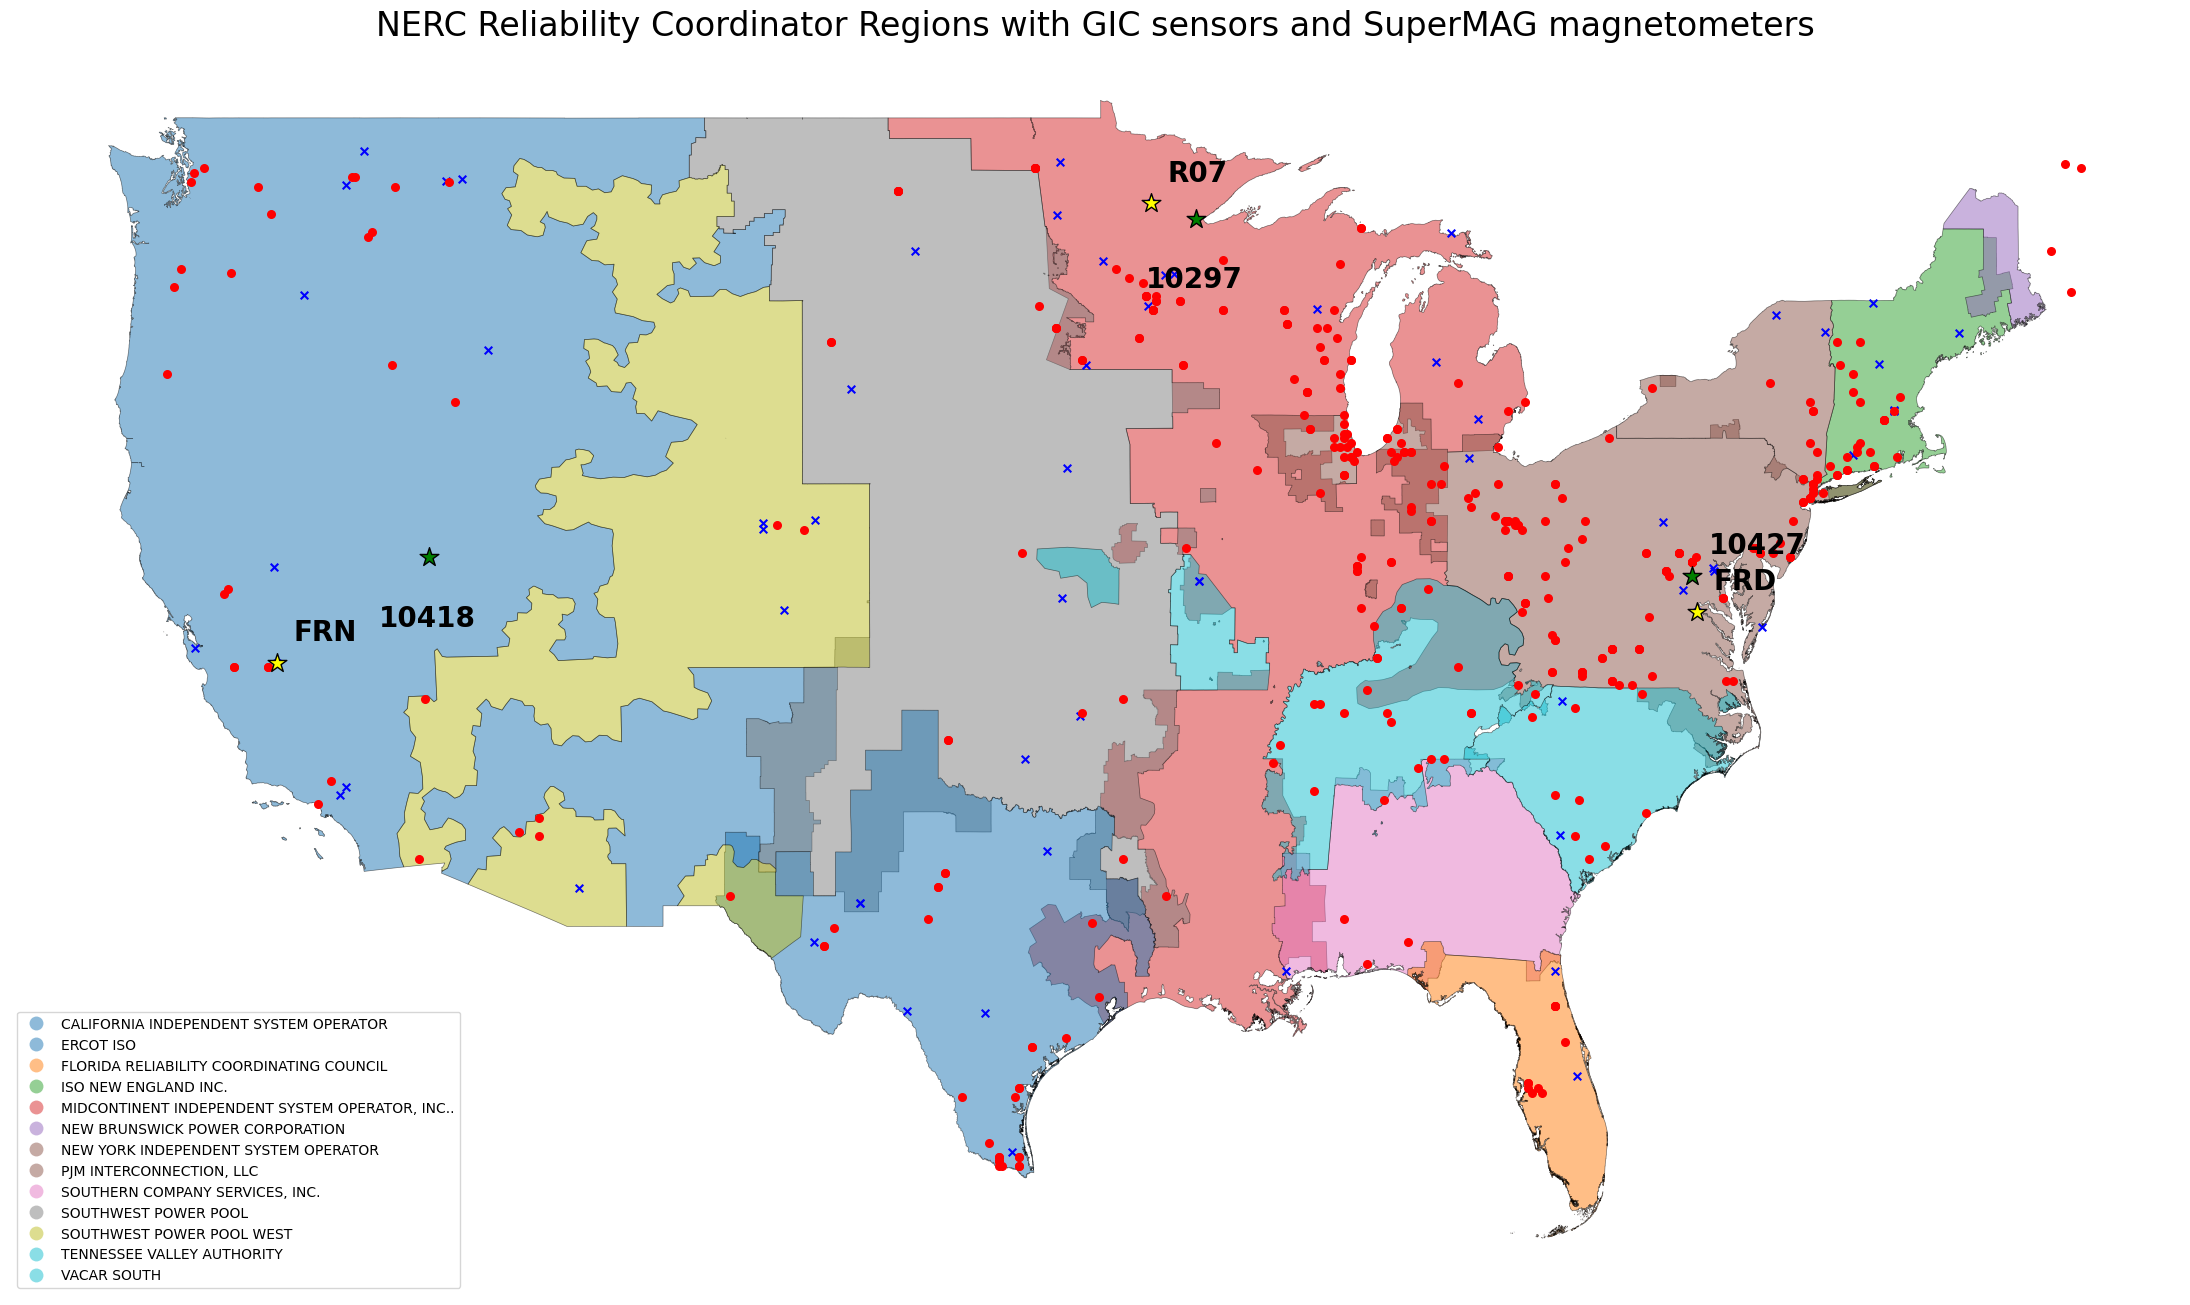

In [13]:
# Plot the data for this event
fig, ax = plt.subplots(1, 1, figsize=(22, 16))

# Select the stations of interest
highlight_stations = sm_stations_locations_with_regions_US[
    # sm_stations_locations_with_regions_US['IAGA'].isin(['R02', 'R05','R07', 'FRD', 'FRN'])
    sm_stations_locations_with_regions_US['IAGA'].isin(['R07', 'FRD', 'FRN'])
]
highlight_sensors = gdf_sensor_locations[
    gdf_sensor_locations['Device ID'].isin([10427,10418,10297])
]

# Plot the NERC RC regions colored by region name or code
regions_gdf.plot(column='NAME', categorical=True, legend=True, 
        edgecolor='black', linewidth=0.5, ax=ax, alpha=0.5)

# Plot sensor locations
sm_stations_locations_with_regions_US.plot(ax=ax, marker='x',color='blue', markersize=30, label='Magnetometers')
gdf_sensor_locations.plot(ax=ax, color='red', markersize=30, label='Sensors')

# Plot highlighted stations with bigger markers
highlight_stations.plot(ax=ax, color='yellow', edgecolor='black', markersize=200, marker='*', label='Highlighted Stations')

# Add text labels so they’re clearly indicated
for x, y, label in zip(highlight_stations.geometry.x, highlight_stations.geometry.y, highlight_stations['IAGA']):
    ax.text(x + 0.5, y + 0.5, label, fontsize=20, fontweight='bold', color='black')

# Plot highlighted sensors with bigger markers
highlight_sensors.plot(ax=ax, color='green', edgecolor='black', markersize=200, marker='*', label='Highlighted Sensors')

# Add text labels so they’re clearly indicated
for x, y, label in zip(highlight_sensors.geometry.x, highlight_sensors.geometry.y, highlight_sensors['Device ID']):
    if label == 10427:
        ax.text(x + 0.5, y + 0.5, label, fontsize=20, fontweight='bold', color='black')
    else:
        ax.text(x - 1.5, y - 1.5, label, fontsize=20, fontweight='bold', color='black')

ax.set_title('NERC Reliability Coordinator Regions with GIC sensors and SuperMAG magnetometers', fontsize=24)
ax.set_axis_off()
# ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

TODO: look at 10448 -> move to 10418

In [ ]:
sm_stations_region = {}

grouped = sm_stations_locations_with_regions_US.groupby('Region')
for region, region_data in grouped:
    sm_stations_region[region] = [region_data['IAGA'],region_data['GEOLON_alt'],region_data['GEOLAT']]

In [ ]:
sm_stations_region['MIDCONTINENT INDEPENDENT SYSTEM OPERATOR, INC..']

In [ ]:
years = np.arange(2013,2025)
print(years)

In [ ]:
datetime(years[0],6,1)

In [ ]:
(status,stations) = supermag_api.SuperMAGGetInventory(supermag_userid,
                                                          datetime(years[0],1,1),
                                                         86400*365)

In [ ]:
supermag_userid = 'rymc1012'
flags = 'geo'


In [ ]:
# (status,sm_data)=supermag_api.SuperMAGGetData(supermag_userid,
#                                      datetime(years[0],1,1),
#                                      86400*365,
#                                      flags,'FRN')

In [29]:
# Downloaded 2024 data for FRD, FRN, and R05
file_FRD = '/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/supermag_data/SuperMAG_60s_FRD_2024_rev-0006.1753287357.netcdf'
# ds = xr.open_dataset(file_FRD)
ds = xr.open_dataset(file_FRD, chunks={'time': 10000})

In [ ]:
for var in ['time_yr', 'time_mo', 'time_dy', 'time_hr', 'time_mt', 'time_sc']:
    ds[var] = ds[var].astype(int)

In [ ]:
ds = ds.drop_vars(['extent','dbe_geo','dbn_geo','dbn_geo'])

In [ ]:
ds

In [ ]:
def build_datetime_vec(y, mo, d, h, mi, s):
    y = y.astype(str)
    mo = np.char.zfill(mo.astype(str), 2)
    d = np.char.zfill(d.astype(str), 2)
    h = np.char.zfill(h.astype(str), 2)
    mi = np.char.zfill(mi.astype(str), 2)
    s = np.char.zfill(s.astype(str), 2)
    
    dt_str = np.char.add(y, '-')
    dt_str = np.char.add(dt_str, mo)
    dt_str = np.char.add(dt_str, '-')
    dt_str = np.char.add(dt_str, d)
    dt_str = np.char.add(dt_str, 'T')
    dt_str = np.char.add(dt_str, h)
    dt_str = np.char.add(dt_str, ':')
    dt_str = np.char.add(dt_str, mi)
    dt_str = np.char.add(dt_str, ':')
    dt_str = np.char.add(dt_str, s)
    
    return dt_str.astype('datetime64[ns]')


datetime_da = xr.apply_ufunc(
    build_datetime_vec,
    ds['time_yr'], ds['time_mo'], ds['time_dy'],
    ds['time_hr'], ds['time_mt'], ds['time_sc'],
    dask='allowed',
    output_dtypes=[np.dtype('datetime64[ns]')]
)


# Assign as time coordinate
ds = ds.assign_coords(time=datetime_da)


In [ ]:
# ds = ds.assign_coords(time=pd.to_datetime(datetime_da.values))

In [ ]:
ds['time'] = pd.to_datetime(ds['time'].values)



In [ ]:
H = np.sqrt(ds['dbe_nez']**2 + ds['dbn_nez']**2)
ds['H'] = H

ds['H'] = ds['H'].rename({'block': 'time'})
H_1d = ds['H'].squeeze('vector')  # dims: ('time',)


In [ ]:
dH = ds['H'].diff('time')
dt = ds['time'].diff('time') / np.timedelta64(1, 's')
dt = dt.astype('float64')  # ensure float for safe division


dH_dt = dH / dt
dH_dt = dH_dt.pad(time=(1, 0), constant_values=np.nan)  # align dimensions
ds['dH_dt'] = dH_dt


In [ ]:
ds['dbe_nez'].dims

In [ ]:
#need to explicitly define the 'block' dimension to be the 'time'dimension for .diff() to work correctly

# ds['dbe_nez'] = ds['dbe_nez'].assign_coords(block=ds['time'])
# ds['dbn_nez'] = ds['dbn_nez'].assign_coords(block=ds['time'])
# ds = ds.rename_dims({'block': 'time'})  # rename dimension so it's usable
ds = ds.rename({'block': 'time'})       # rename coordinate to match

In [ ]:
ds['dbe_nez'].dims
#should be (time, vector)

In [ ]:
# calculating the variation that MacManus found best related to GIC H: the first difference (E_t-E_(t-1) or N_t-N(t-1)) in the two horizontal directions and ,
#    https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2025SW004404
dbe_dt = ds['dbe_nez'].diff('time')
dbn_dt = ds['dbn_nez'].diff('time')

# Combine
mag_dH_dt = np.sqrt(dbe_dt**2 + dbn_dt**2)

# Pad to match original time length
mag_dH_dt = mag_dH_dt.pad(time=(1, 0), constant_values=np.nan)

# Rebuild DataArray with proper coordinates
mag_dH_dt = xr.DataArray(
    data=mag_dH_dt.data,
    dims=['time', 'vector'],
    coords={
        'time': ds['time'],
        'vector': ds['vector'] if 'vector' in ds.coords else [0]  # dummy if missing
    },
    name='mag_db_dt'
)

# Assign to dataset
ds['mag_db_dt'] = mag_dH_dt


In [ ]:
%%time

ds['mag_db_dt'] = ds['mag_db_dt'].compute()

In [ ]:
ds['mag_db_dt']

In [ ]:
ds['dH_dt']

In [ ]:
import plotly.graph_objects as go

# Subset dataframe (already done)
# df_subset = ds[['H', 'dH_dt']].isel(time=slice(0, 10000)).to_dataframe().reset_index()
df_subset = ds[['H', 'mag_db_dt']].isel(time=slice(0, 10000)).to_dataframe().reset_index()

fig = go.Figure()

# Add H trace (left y-axis)
fig.add_trace(go.Scatter(
    x=df_subset['time'],
    y=df_subset['H'],
    name='H (nT)',
    line=dict(color='blue'),
    yaxis='y1'
))

# # Add dH/dt trace (right y-axis)
# fig.add_trace(go.Scatter(
#     x=df_subset['time'],
#     y=df_subset['dH_dt'],
#     name='dH/dt (nT/min)',
#     line=dict(color='red'),
#     yaxis='y2'
# ))

# Add mag of the time rate of change of the horizontal magn field to left y-axis
fig.add_trace(go.Scatter(
    x=df_subset['time'],
    y=df_subset['mag_db_dt'],  # Example: some transformation or different variable
    name='time rate of change (nT/min)',
    line=dict(color='green', dash='dash'),
    yaxis='y2'
))


# Create axis objects
fig.update_layout(
    title='H, dH/dt, and magn(time rate of change) (First X points)',
    xaxis=dict(title='Time'),
    yaxis=dict(
        title='H (nT)',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue'),
        side='left'
    ),
    yaxis2=dict(
        title='dH/dt (nT/min) or magn(db/dt)',
        titlefont=dict(color='red'),
        tickfont=dict(color='red'),
        overlaying='y',
        side='right'
    ),
    height=600,
    legend=dict(x=0.1, y=1.1, orientation='h')
)

fig.show()


In [ ]:
ds['dbe_nez'].compute()

In [ ]:
# dbe_dt.compute()
# dbn_dt.compute()
dbe_dt.values[0:1000]


In [ ]:
import plotly.graph_objects as go

# Subset dataframe (already done)
plt.plot(ds['time'].values[0:1000],ds['dbe_nez'].values[0:1000],color='b')
plt.plot(ds['time'].values[0:1000],ds['dbn_nez'].values[0:1000],color='r')
plt.plot(ds['time'].values[0:1000],dbe_dt.values[0:1000],'b--')
plt.plot(ds['time'].values[0:1000],dbn_dt.values[0:1000],'r--')

plt.show()



In [ ]:
# block_max_H = H_da.resample(time='D').max()
# block_max_dHdt = dHdt_da.resample(time='D').max()

In [ ]:
# H_da = xr.DataArray(ds['H'].data, dims=['time'], coords={'time': ds.coords['time']})
# dHdt_da = xr.DataArray(ds['dH_dt'].data, dims=['time'], coords={'time': ds.coords['time']})

# block_max_H = H_da.resample(time='D').max()
# block_max_dHdt = dHdt_da.resample(time='D').max()

In [ ]:
#EVA 


# # Resample to monthly block maxima
# block_max_H = ds['H'].resample(time='M').max()
# block_max_dHdt = ds['dH_dt'].resample(time='M').max()

# Resample to daily block maxima
block_max_H = ds['H'].resample(time='D').max()
block_max_dHdt = ds['dH_dt'].resample(time='D').max()
block_max_magdbdt = ds['mag_db_dt'].resample(time='D').max()


# Drop NaNs
block_H = block_max_H.values
block_H = block_H[np.isfinite(block_H)]

# Fit GEV
shape_H, loc_H, scale_H = genextreme.fit(block_H)


# Drop NaNs
block_magdbdt = block_max_magdbdt.values
block_magdbdt = block_magdbdt[np.isfinite(block_magdbdt)]

# Fit GEV
shape_magdbdt, loc_magdbdt, scale_magdbdt = genextreme.fit(block_magdbdt)


In [ ]:

# Compute theoretical quantiles
percs = np.linspace(0, 100, len(block_H))
q_empirical = np.percentile(block_H, percs)
q_theoretical = genextreme.ppf(percs / 100, shape_H, loc=loc_H, scale=scale_H)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(q_theoretical, q_empirical, c='blue', label='Data')
plt.plot(q_theoretical, q_theoretical, 'r--', label='1:1 Line')
plt.xlabel('Theoretical Quantiles (GEV)')
plt.ylabel('Empirical Quantiles (Data)')
plt.title('Q-Q Plot for H Block Maxima (GEV Fit)')
plt.legend()
plt.grid(True)
plt.show()


# Compute theoretical quantiles
percs = np.linspace(0, 100, len(block_magdbdt))
q_empirical = np.percentile(block_magdbdt, percs)
q_theoretical = genextreme.ppf(percs / 100, shape_magdbdt, loc=loc_magdbdt, scale=scale_magdbdt)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(q_theoretical, q_empirical, c='blue', label='Data')
plt.plot(q_theoretical, q_theoretical, 'r--', label='1:1 Line')
plt.xlabel('Theoretical Quantiles (GEV)')
plt.ylabel('Empirical Quantiles (Data)')
plt.title('Q-Q Plot for mag(db/dt) Block Maxima (GEV Fit)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Return Level Plot
return_periods = np.linspace(1, 100, 100)
p = 1 - 1 / (return_periods * 365.25)
return_levels_H = genextreme.ppf(p, shape_H, loc=loc_H, scale=scale_H)

plt.figure(figsize=(8, 6))
plt.plot(return_periods, return_levels_H, marker='o')
plt.xlabel('Return Period (Years)')
plt.ylabel('Return Level of H (nT)')
plt.title('Return Level Plot for H Daily Maxima')
plt.grid(True)
plt.show()


# Return Level Plot
return_periods = np.linspace(1, 100, 100)
p = 1 - 1 / (return_periods * 365.25)
return_levels_magdbdt = genextreme.ppf(p, shape_magdbdt, loc=loc_magdbdt, scale=scale_magdbdt)

plt.figure(figsize=(8, 6))
plt.plot(return_periods, return_levels_magdbdt, marker='o')
plt.xlabel('Return Period (Years)')
plt.ylabel('Return Level of mag(db/dt) (nT)')
plt.title('Return Level Plot for mag(db/dt) Daily Maxima')
plt.grid(True)
plt.show()


In [16]:
# developing the capability to identify the closest GIC sensor to the given magnetometer

# choose, for now, the Gannon storm 
gic_sensors_locations_file = '/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20240510/GIC/gic_monitors.csv'

df_gic_sensors = pd.read_csv(gic_sensors_locations_file)



In [17]:
df_gic_sensors[' Longitude'] = df_gic_sensors[' Longitude'] * -1.

In [20]:

# Example: your dataframe of sensors
# Assume df has columns: ['sensor_id', 'latitude', 'longitude']
# And your target location:
glat_mag = ds['glat'].values[0]
glon_mag = ds['glon'].values[0]
target_lat = glat_mag[0]     # example latitude
target_lon = glon_mag[0]   # example longitude
print('target lat,long = ({},{})'.format(target_lat,target_lon))

# Convert degrees to radians
lat_rad = np.radians(df_gic_sensors[' Latitude'])
lon_rad = np.radians(df_gic_sensors[' Longitude'])
target_lat_rad = np.radians(target_lat)
target_lon_rad = np.radians(target_lon)

# Haversine formula
dlat = lat_rad - target_lat_rad
dlon = lon_rad - target_lon_rad

a = np.sin(dlat / 2)**2 + np.cos(lat_rad) * np.cos(target_lat_rad) * np.sin(dlon / 2)**2
c = 2 * np.arcsin(np.sqrt(a))
R = 6371  # Earth radius in kilometers
distances_km = R * c

# Add distances to DataFrame
df_gic_sensors['distance_km'] = distances_km

# Get the top 10 closest sensors
closest = df_gic_sensors.nsmallest(10, 'distance_km')

print(closest[['Device ID', ' Latitude', ' Longitude', 'distance_km']])


NameError: name 'ds' is not defined

In [19]:

# Get top 10 closest
df_gic_sensors['is_closest'] = False
df_gic_sensors.loc[df_gic_sensors.nsmallest(10, 'distance_km').index, 'is_closest'] = True

# Add the target location
df_target = pd.DataFrame({
    'Device ID': ['Target'],
    ' Latitude': [target_lat],
    ' Longitude': [target_lon],
    'distance_km': [0],
    'is_closest': [True]
})

df_plot = pd.concat([df_gic_sensors, df_target], ignore_index=True)

# Plot with Plotly
fig = px.scatter_geo(df_plot,
    lat=' Latitude',
    lon=' Longitude',
    hover_name='Device ID',
    color='is_closest',
    symbol='is_closest',
    scope='usa',
    color_discrete_map={True: 'red', False: 'blue'},
    title='Sensor Locations and Closest Sensors to Target',
    height=600
)
fig.update_traces(marker=dict(size=8))
fig.show()

print('note that for these sensors, five of them are essentially in the same location')

KeyError: 'distance_km'

In [ ]:
# Read in the GIC data for these close sensors 

file_gic_data = '/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/integrated_data/integrated_data_event_20240510.csv'
df_gic_data = pd.read_csv(file_gic_data,index_col=False)
if 'Unnamed: 0' in df_gic_data.columns:
    df_gic_data = df_gic_data.drop(columns='Unnamed: 0')

# Drop unwanted columns, but save IMF and AE index columns
cols_to_drop_loc = df_gic_data.columns.get_loc('AE_INDEX')
df_gic_data.columns.to_list()[cols_to_drop_loc:]
df_gic_data = df_gic_data.drop(df_gic_data.columns.to_list()[cols_to_drop_loc:],axis = 1)

df_gic_data['datetimes'] = pd.to_datetime(df_gic_data['datetimes'])
df_gic_data = df_gic_data.set_index('datetimes')

In [ ]:
mag_selected_data = ds.sel(time=slice('2024-05-10','2024-05-11'))
mag_db_dt = mag_selected_data['mag_db_dt']
mag_db_dt_df = mag_db_dt.squeeze('vector').to_dataframe(name='mag_db_dt')


In [ ]:
mag_db_dt_df

In [ ]:

# Let's say:
# df_values: DataFrame with sensor data (columns = sensor IDs)
# mag_db_dt: Series with same time index
# nearest_ids: list of sensor IDs (subset of df_values.columns)

fig = go.Figure()

nearest_ids = closest['Device ID'].values
# Add each nearest sensor trace on y-axis 1
for sensor_id in nearest_ids:
    try:
        fig.add_trace(go.Scatter(
            x=df_gic_data.index,
            y=df_gic_data[str(sensor_id)],
            name=f'Sensor {sensor_id}',
            yaxis='y1',
            mode='lines'
        ))
    except Exception as e:
        print('catching exception {}, advancing...'.format(e))
        

# Add mag_db_dt on y-axis 2
fig.add_trace(go.Scatter(
    x=mag_db_dt_df.index,
    y=mag_db_dt_df['mag_db_dt'],
    name='mag_db_dt',
    yaxis='y2',
    mode='lines',
    line=dict(color='black', width=2, dash='dash')
))

# Layout with dual axes
fig.update_layout(
    title='Sensor Values and mag_db_dt',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Sensor Values', side='left'),
    yaxis2=dict(title='mag_db_dt (nT/s)', overlaying='y', side='right'),
    legend=dict(x=0.01, y=0.99),
    height=600
)

fig.show()


In [ ]:

# Let's say:
# df_values: DataFrame with sensor data (columns = sensor IDs)
# mag_db_dt: Series with same time index
# nearest_ids: list of sensor IDs (subset of df_values.columns)

fig = go.Figure()

nearest_ids = closest['Device ID'].values
# Add each nearest sensor trace on y-axis 1
for sensor_id in nearest_ids:
    try:
        fig.add_trace(go.Scatter(
            x=df_gic_data.index,
            y=abs(df_gic_data[str(sensor_id)].diff()),
            name=f'abs(dt(Sensor {sensor_id}))',
            yaxis='y1',
            mode='lines'
        ))
        fig.add_trace(go.Scatter(
            x=df_gic_data.index,
            y=abs(df_gic_data[str(sensor_id)]),
            name=f'abs(Sensor {sensor_id})',
            yaxis='y1',
            mode='lines'
        ))
    except Exception as e:
        print('catching exception {}, advancing...'.format(e))
        

# Add mag_db_dt on y-axis 2
fig.add_trace(go.Scatter(
    x=mag_db_dt_df.index,
    y=mag_db_dt_df['mag_db_dt'],
    name='mag_db_dt',
    yaxis='y2',
    mode='lines',
    line=dict(color='black', width=2, dash='dash')
))

# Layout with dual axes
fig.update_layout(
    title='abs(time diff of Sensor Values) and mag_db_dt',
    xaxis=dict(title='Time'),
    yaxis=dict(title='abs( (time diff of) Sensor Values)', side='left'),
    yaxis2=dict(title='mag_db_dt (nT/s)', overlaying='y', side='right'),
    legend=dict(x=0.01, y=0.99),
    height=600
)

fig.show()


In [ ]:
# EVA for GIC sensors that are close
nearest_ids = closest['Device ID'].values

    
# Load integrated data files
integrated_data_directory = '/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/integrated_data/'
files = glob.glob( os.path.join(integrated_data_directory,'*.csv') )

# Histogram initializations
    # Define the histogram bins between 0 and 100
bins = np.linspace(0, 100, num=101)  # 101 edges for 100 bins
bin_centers = (bins[:-1] + bins[1:]) / 2  # Calculate bin centers for plotting later

    # Initialize an empty dictionary to store histograms for each region
year_data = {}
sensors_location_data = {}
histogram_data = {}
extreme_value_data = {}

for f in files:

    # read in the numerical data for the sensors in this event
    df_tmp = pd.read_csv(f,index_col=False)
    if 'Unnamed: 0' in df_tmp.columns:
        df_tmp = df_tmp.drop(columns='Unnamed: 0')

    # read in the lat-long values for the sensors in this event
    print('\n\n\n\n----------------------------\nworking on event: {}'.format(f[97:-4])) #f.find('event')
    print('\t--->{}'.format(f))
    file_sensor_locations = os.path.join('/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/','risk-resiliency-spwx','data',f[97:-4],'GIC','gic_monitors.csv')

    print('\t--->{}'.format(file_sensor_locations))
    df_sensor_locations_tmp = pd.read_csv(file_sensor_locations)
    df_sensor_locations_tmp[' Longitude'] = df_sensor_locations_tmp[' Longitude'] * -1.
    
    # Drop unwanted columns
    cols_to_drop_loc = df_tmp.columns.get_loc('AE_INDEX')
    df_tmp = df_tmp.drop(df_tmp.columns.to_list()[cols_to_drop_loc:],axis = 1)

    # Loop through close sensors
    for sensor_id in nearest_ids:

        # Initialize histogram for this region if not already present
        if sensor_id not in histogram_data:
            year_data[sensor_id] = []
            histogram_data[sensor_id] = np.zeros(len(bins) - 1)
            extreme_value_data[sensor_id] = []#np.array(())

        year_data[sensor_id].append(int(f[103:-8]))
        try:
            device_data = df_tmp[str(sensor_id)]
        except:
            print('missing device ID = {}, continuing...'.format(sensor_id))
            continue


        counts, _ = np.histogram(device_data.values, bins=bins)
        max_val_device = np.nanmax( abs(device_data.values) )
        
        # Add these counts to the region's histogram
        histogram_data[sensor_id] += counts
        extreme_value_data[sensor_id].append(max_val_device)



In [ ]:
for s in nearest_ids: 
    print('\n--------------------\nData details for: {}'.format(s))

    print('\t Years in the data: {} (and number: {})'.format(set(year_data[s]), len(set(year_data[s])) ))
    print('\t Extreme values: {}'.format( np.sort(extreme_value_data[s]) ))
    

    print('\n\n')

In [ ]:
# choose a region and do full PHA

extreme_value_fits = {}


# Step One: plot histogram
key = 10427
data_pha = histogram_data[key]
# data_eva = extreme_value_data[key]

# Convert data to a Pandas DataFrame for use with Plotly
df_pha = pd.DataFrame({key: data_pha})

# Create a histogram using Plotly Express
fig = px.bar(
        df_pha,
        x=bin_centers, 
        y=data_pha,
        title=key,
        template="plotly_white",
        labels={"GIC values", "Frequency"},
        opacity=0.5  # 50% transparent bars
    )

# Customize the layout for publication quality
fig.update_layout(
    title=dict(font=dict(size=18, family="Arial"), x=0.5),
    xaxis=dict(title=dict(font=dict(size=14)), tickangle=45),
    yaxis=dict(title=dict(font=dict(size=14))),
    font=dict(size=12, family="Arial"),
    width=800,
    height=600
)
# fig.update_yaxes(type="log")

# Show the figure
fig.show()

# Step two: fit a GEV distribution

plt.figure(figsize=(8, 6), dpi=300)
for sensor_eva, e in extreme_value_data.items():

    if sensor_eva == key:
        gev_params = genextreme.fit(e)
        
        # Extract GEV parameters
        shape, loc, scale = gev_params
        print(f"GEV Parameters for sensor_eva {sensor_eva}:\nShape: {shape}, Location: {loc}, Scale: {scale}")
        extreme_value_fits[sensor_eva] = [shape,loc,scale]
        
        # Generate x values for plotting
        x = np.linspace(min(e), max(e), 100)
        
        # Compute the PDF of the fitted GEV distribution
        pdf = genextreme.pdf(x, shape, loc=loc, scale=scale)
        
        # Plot histogram and GEV PDF
        plt.hist(e, bins=25, density=True, alpha=0.7, color='blue', edgecolor='black', label='Empirical Data')
        plt.plot(x, pdf, 'r-', label='GEV Fit')
        plt.title('Extreme Values and GEV Fit for '+str(key), fontsize=14, fontweight="bold")
        
        plt.xlabel('GIC', fontsize=12)
        plt.ylabel('Density', fontsize=12)

        # Grid and legend
        plt.grid(visible=True, linestyle="--", alpha=0.5)
        
        # Tight layout for better spacing
        plt.tight_layout()
        plt.savefig("/Users/ryanmc/Documents/Conferences/AGU2024/poster_figures/risk_science/eva_gev.png", format="png", dpi=300)
        
        # Show the figure
        plt.show()


# Step three: get return periods
for sensor_eva, e in extreme_value_fits.items():
    if sensor_eva == key:
        # Define return periods (in years)
        # return_periods = np.array([10, 20, 50, 100])
        return_periods = np.array([1,5,10,15,20])
        
        # Calculate return levels
        return_levels = genextreme.isf(1 / return_periods, e[0], loc=e[1], scale=e[2])
        
        # Display results
        for rp, rl in zip(return_periods, return_levels):
            print(f"Return Period for sensor_eva {sensor_eva}: {rp} years, Return Level: {rl:.2f}")
    
    
        plt.figure()
        plt.plot(return_periods, return_levels, marker='o', label='Return Levels')
        plt.title('Return Levels vs Return Periods for '+str(sensor_eva))
        plt.xlabel('Return Period (years)')
        plt.ylabel('Return Level')
        plt.xscale('log')  # Log scale for better visualization
        
        # Grid and legend
        plt.grid(visible=True, linestyle="--", alpha=0.5)
        
        # Tight layout for better spacing
        plt.tight_layout()
        plt.savefig("/Users/ryanmc/Documents/Conferences/AGU2024/poster_figures/risk_science/return_periods.png", format="png", dpi=300)
        
        # Show the figure
        plt.show()